In [18]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import os
import shutil
import posixpath
import wfdb
import seaborn as sn

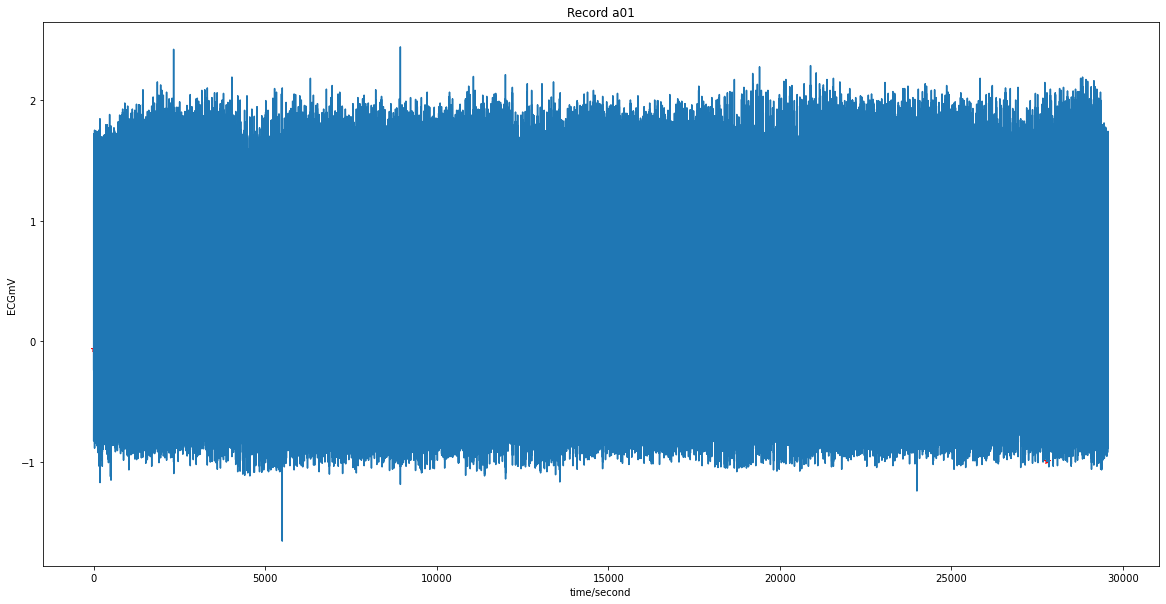

In [19]:
# docs: https://wfdb.readthedocs.io/en/latest/wfdb.html
# SpO2が含まれているデータは a01r のようにrが付いている
# records

# 'a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r'
subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r', 'c03r']
records = {}

# データの読み込み
for subject in subjects:
    path = "dataset/" + subject
    records[subject] = wfdb.rdrecord(path)  # 計測データ
    records['ann_' + subject] = wfdb.rdann(path, 'apn', shift_samps=True) # ラベル

record = wfdb.rdrecord('dataset/a01')
annotation = wfdb.rdann('dataset/a01', 'apn', shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, title='Record a01', time_units='seconds', figsize=(20,10)) 
#display(records['a01r'].__dict__)

In [20]:
# https://archive.physionet.org/physiobank/database/apnea-ecg/annotations.shtml
# display(annotation.__dict__)
display(len(records['ann_a01r'].sample))
display(len(records['ann_a01r'].symbol))

3108000 / 6000
print(records['ann_a01r'].symbol)

489

489

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',

In [21]:
# print(record.p_signal.size)  # 4つの信号×時間 = サイズ
# 4信号で割ってアノテーションの個数で割ると大体6000sampleになる
# https://www.physionet.org/lightwave/?db=apnea-ecg/1.0.0 でテストデータを確認できる
# a03rの場合、08:37:50以降はアノテーションの記録がない

print(records['a01r'].p_signal.size / 4 / 489)

6046.617586912065


In [25]:
# 特徴量の抽出、学習用のデータ作成
# 1 sample(6000個のデータ)毎に基本統計量を出してそれをInputに与える
# 例) record.p_signal[0:6000], record.p_signal[6001:12001]で統計量を出す
        
def extract_feature(data):
    return np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])

# train用
train_subjects = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01r', 'c02r']

# test用
test_subjects = ['c03r']

data_array = []
for subject in train_subjects:
    # annotation分だけ繰り返す
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print('---train_subjects---')
    print(data.head())
    print(data.isnull().sum())

    # 基本統計量を出す
    # data.describe()
    # ピークの差 (data.max() - data.min()).values
    # np.hstack([data.mean().values, data.std().values, data.max().values, data.min().values])
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        data_array.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000

test_data = []
for subject in test_subjects:
    ann_count = len(records['ann_'+subject].sample)
    data = pd.DataFrame(records[subject].p_signal, columns=records[subject].sig_name, dtype='float')
    print('---train_subjects---')
    print(data.head())
    print(data.isnull().sum())
    start_idx = 0
    end_idx = 6000
    for n in range(0, ann_count):
        test_data.append(extract_feature(data[start_idx:end_idx]))
        start_idx = end_idx + 1
        end_idx = end_idx + 6000


---train_subjects---
   Resp C  Resp A   Resp N  SpO2
0 -0.1015 -0.3446  0.23545  98.0
1 -0.1025 -0.3455  0.23640  98.0
2 -0.1035 -0.3464  0.23735  98.0
3 -0.1045 -0.3473  0.23830  98.0
4 -0.1055 -0.3482  0.23925  98.0
Resp C     21
Resp A    549
Resp N      0
SpO2        0
dtype: int64
---train_subjects---
    Resp C   Resp A   Resp N  SpO2
0 -0.08525  0.22005 -0.41895  96.0
1 -0.08435  0.20915 -0.40935  96.0
2 -0.08345  0.19830 -0.39980  96.0
3 -0.08260  0.18740 -0.39030  96.0
4 -0.08170  0.17655 -0.38070  96.0
Resp C      82
Resp A    1411
Resp N       0
SpO2         0
dtype: int64
---train_subjects---
    Resp C   Resp A   Resp N  SpO2
0 -0.06790 -0.06185 -0.50170  92.0
1 -0.06695 -0.06105 -0.50270  92.0
2 -0.06605 -0.06030 -0.50375  92.0
3 -0.06510 -0.05955 -0.50475  92.0
4 -0.06420 -0.05880 -0.50580  92.0
Resp C    190
Resp A     23
Resp N      0
SpO2        0
dtype: int64
---train_subjects---
    Resp C   Resp A   Resp N  SpO2
0 -0.14035 -0.14400  0.10895  93.0
1 -0.14060 -0.146

In [7]:
# 学習データ作成
print(len(data_array))
train_X = np.array(data_array)

print(train_X[0].size)
print(train_X[1])
type(train_X)

train_X.shape

# テストデータ作成
print(len(test_data))
test_X = np.array(test_data)
test_X.shape

3501
16
[-5.64733956e-02 -4.05511169e-02  2.24443074e-02  9.73498916e+01
  5.26096529e-02  1.58064974e-01  1.38697215e-01  6.78662729e-01
  8.91000000e-02  5.25450000e-01  3.17350000e-01  9.80000000e+01
 -1.90200000e-01 -4.06650000e-01 -2.87250000e-01  9.60000000e+01]
454


(454, 16)

In [8]:
# NとAを1,0に変換する
from sklearn.preprocessing import LabelEncoder

label_data = []
for subject in train_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    labels = le.transform(records['ann_' + subject].symbol)
    label_data = np.concatenate([label_data, labels], 0)

# テスト用のラベル
test_label = []
for subject in test_subjects:
    le = LabelEncoder()
    le = le.fit(records['ann_' + subject].symbol)
    test_label = le.transform(records['ann_' + subject].symbol)
    
display(label_data)
display(len(label_data))

display(test_label)
display(len(test_label))

array([1., 1., 1., ..., 1., 1., 1.])

3501

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

454

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


# モデルの作成
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(16, 1)),
    keras.layers.Dense(30, activation='sigmoid'),
    keras.layers.Dense(30, activation='sigmoid'),
    keras.layers.Dense(1, activation='softmax')
])

In [10]:
from keras import optimizers
from keras.utils import plot_model

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,471
Trainable params: 1,471
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(train_X, label_data,
                    batch_size=64,
                    epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 1ms/step - loss: 0.6568 - accuracy: 0.4071
Epoch 2/100
55/55 [==============================] - 0s 1ms/step - loss: 0.5714 - accuracy: 0.4105
Epoch 3/100
55/55 [==============================] - 0s 1ms/step - loss: 0.5082 - accuracy: 0.3992
Epoch 4/100
55/55 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.4042
Epoch 5/100
55/55 [==============================] - 0s 1ms/step - loss: 0.4232 - accuracy: 0.3949
Epoch 6/100
55/55 [==============================] - 0s 1ms/step - loss: 0.4056 - accuracy: 0.3891
Epoch 7/100
55/55 [==============================] - 0s 1ms/step - loss: 0.3993 - accuracy: 0.4072
Epoch 8/100
55/55 [==============================] - 0s 1ms/step - loss: 0.3980 - accuracy: 0.4013
Epoch 9/100
55/55 [==============================] - 0s 1ms/step - loss: 0.3973 - accuracy: 0.4063
Epoch 10/100
55/55 [==============================] - 0s 1ms/step - loss: 0.3899 - accuracy: 0.4033
Epoch 11/

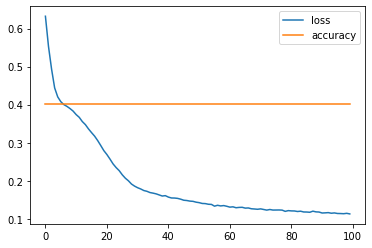

In [12]:
# plotしてみる
pd.DataFrame(history.history)[['loss', 'accuracy']].plot()

In [13]:
print("Evaluate on test data")
results = model.evaluate(test_X, test_label, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 100 samples")
predictions = model.predict(test_X[:100])
print("predictions shape:", predictions.shape)

Evaluate on test data
4/4 [==============================] - 0s 2ms/step - loss: 3.9287 - accuracy: 0.0000e+00
test loss, test acc: [3.928692102432251, 0.0]
Generate predictions for 100 samples
predictions shape: (100, 1)


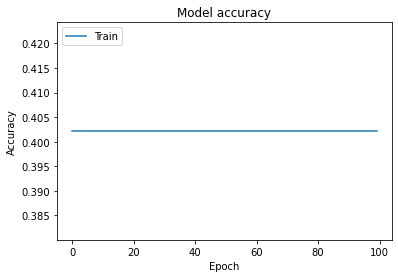

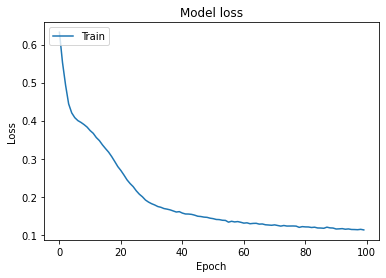

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()